In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='UmuWJ1wfB9i_GshiIUnLdsIVQJevwFvzN4n8kyoEkXHL',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'waterqualitypredictor-donotdelete-pr-tanesbvu4upv3x'
object_key = 'water_data.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

In [3]:
df = df.iloc[0:1900, :]
df.shape

(1900, 12)

In [4]:
# Checking for datatypes of the dataset
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [5]:
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

In [6]:
# Converting object data type to numeric
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

STATION CODE     object
LOCATIONS        object
STATE            object
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

In [7]:
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [8]:
# Checking for missing values
df.isnull().sum().sort_values()

year              0
PH                7
Conductivity     24
DO               30
BOD              42
Temp             89
STATION CODE    120
Tot_col         130
LOCATIONS       183
NI              189
Fec_col         280
STATE           670
dtype: int64

In [9]:
# Replacing NULL values with median of column
# Selecting numeric data
df_num = df.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="median")

df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [10]:
# Filling Categorical missing values
df_cat = df.select_dtypes(include="object")
df_cat.isnull().sum()

STATION CODE    120
LOCATIONS       183
STATE           670
dtype: int64

In [11]:
# Here we can fill these values by obeserving other attributes
# Example - 
pd.set_option('mode.chained_assignment', None)
df_cat_copy = df_cat.copy()

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
# Station Code with value 1330 will have Location - TAMBIRAPARANI which belongs in STATE - TAMIL NADU
# I can replace all the NAN occurences in STATE with TAMILNADU
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [12]:
def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [13]:
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [14]:
def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN


In [15]:
# Filling all state NAN values which have corresponding station code value
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [16]:
df_cat_copy.isnull().sum()

STATION CODE     4
LOCATIONS        2
STATE           12
dtype: int64

In [17]:
df_cat_copy[df_cat_copy["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [18]:
# The first location KABBANI AT MUTHANKARA is in STATE Kerela
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000" # I am setting this according to myself
df_cat_copy["STATION CODE"][1785] = "0000"

In [19]:
df_cat = df_cat_copy
df_cat.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
dtype: int64

In [20]:
df_num.isnull().sum()

Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [21]:
df_final = pd.concat([df_cat, df_num], axis=1)
df_final.isnull().sum()

STATION CODE    2
LOCATIONS       2
STATE           2
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [22]:
# These are the samples which don't contain any attribute
# The filled attributes are median of corresponding columns
# So it is best to remove them
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
260,NaN,NaN,NaN,27.0,6.7,7.3,198.0,1.8965,0.52,233.0,465.0,2013.0
431,NaN,NaN,NaN,27.0,6.7,7.3,198.0,1.8965,0.52,233.0,465.0,2013.0


In [23]:
df_final.isnull().sum()

STATION CODE    0
LOCATIONS       0
STATE           0
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [24]:
df_final.shape

(1898, 12)

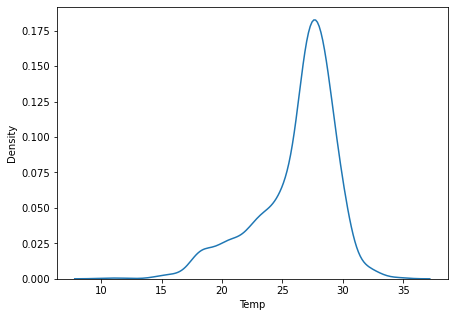

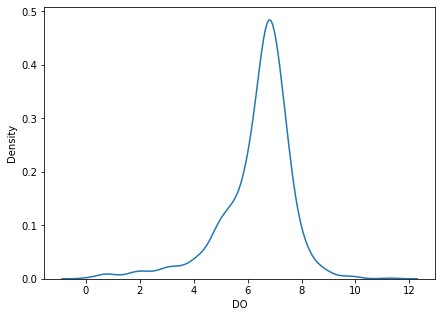

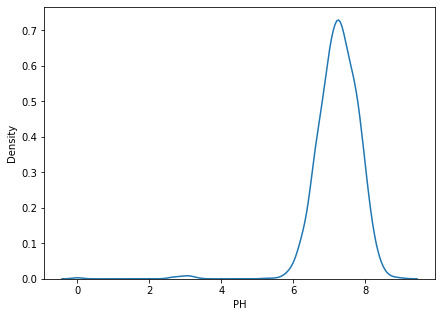

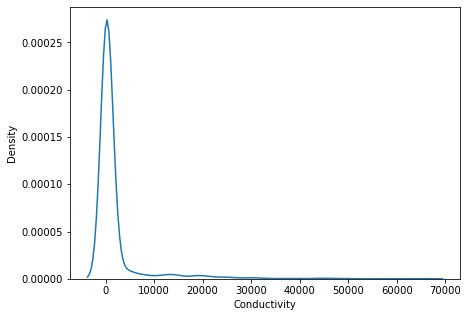

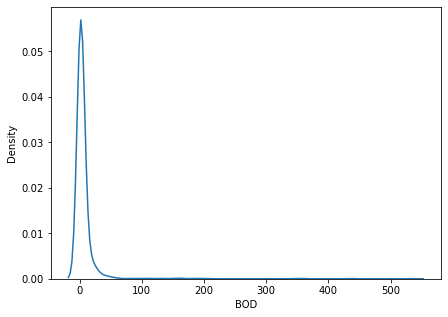

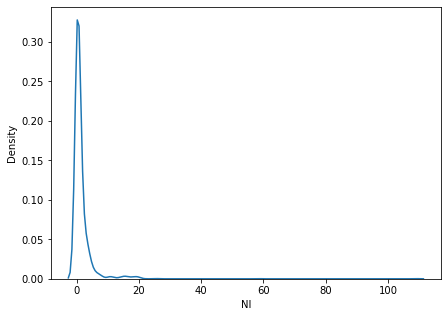

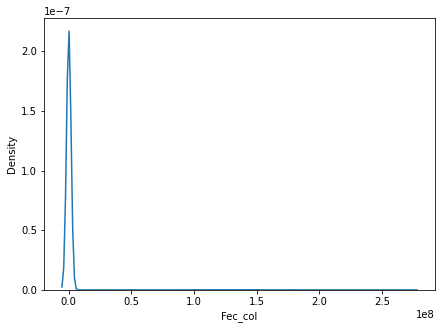

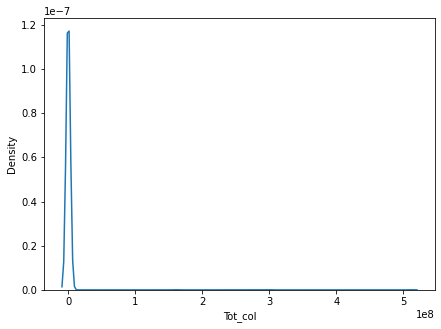

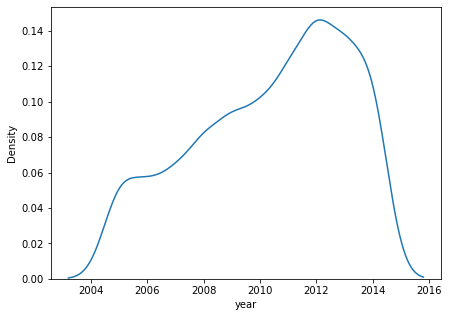

In [26]:
# PLotting PDFs of all the numeric attributes in the dataset

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [27]:
# Here, almost all kde plots are Gaussian Like 
# Using Z-Score Normalization to detect outliers

df_num_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method- 125


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.52,233.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.52,233.0,41.0,2012.0
37,2671,KUNDALIKA RIVER NEAR SALAV BRIDGE (SALINA ZONE...,MAHARASHTRA,25.3,5.3,7.7,24062.0,9.9,1.20,156.0,304.0,2014.0
88,2294,R KALLAI AT KALLAI BRIDGE,KERALA,26.3,3.7,7.7,32005.0,1.2,0.90,40000.0,60392.0,2014.0
108,2304,R MOGRAL AT MOGRAL BR.,KERALA,30.0,5.6,7.2,24360.0,2.1,0.30,92.0,447.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.08,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.90,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.00,1328.0,4975.0,2013.0


In [28]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1785, 12)